<a href="https://colab.research.google.com/github/nanokoperek/Python/blob/master/DL-LSTM-TwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install many_stop_words

#  Wenus - Projekt DL

## Sentiment analysis of Twitter data


In [0]:
import numpy as np
import logging
import random
import pandas as pd
import matplotlib.pylab as plt
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from wordcloud import WordCloud
from many_stop_words import get_stop_words
from keras.models import load_model

from scipy import interp
from itertools import cycle
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec
import gensim
import seaborn as sn
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
#import h5py
from time import time
np.random.seed(7)
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(message)s')

In [0]:
!pip install paramiko

In [0]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [0]:
# Initializing process
logging.debug("Initializing...")
initial_time = time()

#Load dataset
logging.debug("Load dataset")
columns = ["target", "ids", "date", "flag", "user", "text"]
#filename_raw = '/content/gdrive/My Drive/training.1600000.processed.noemoticon.csv'
#filename_shuffled = '/content/gdrive/My Drive/training.1600000.processed.shuffle.csv'

filename_raw = '/content/gdrive/My Drive/training.1600000.processed.noemoticon.csv'
filename_shuffled = '/content/gdrive/My Drive/training.1600000.processed.shuffle.csv'

columns = ["target", "ids", "date", "flag", "user", "text"]
dataset = pd.read_csv(filename_raw,encoding = "ISO-8859-1", delimiter=',',names = columns, engine = None)
#dataset = dataset.iloc[np.random.choice(range(len(dataset)),replace =False)]

dataset = dataset.iloc[np.random.choice(range(len(dataset)), size = 20000,replace =False)]
dataset.index = range(len(dataset))

#dataset = pd.read_csv(filename_raw,sep=',',names = columns)
#dataset = pd.read_csv(filename_shuffled,names=columns,delimiter = ",", nrows=20000)
#dataset.apply(np.random.permutation, axis=1)

logging.debug("Dataset keys: %s" %str(dataset.keys()))

print(dataset.keys())

# Initial data preparation
logging.debug("Initial data preparation")
#dataset['text'] = pd.dataset['text'].str.lower()
dataset = dataset[dataset['text'].notnull() & dataset['target'].notnull()]
print(dataset['target'].unique())

print(dataset.head(10))

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

#Replacing punctuation
dfClean = pd.DataFrame(columns=['text'])
for i in dataset['text']:
    for j in string.punctuation:
        i = i.replace(j, ' ')
    dfClean = dfClean.append({'text': i}, ignore_index=True)
    

print(dataset.head(10))


2019-04-14 10:09:04,313 DEBUG Initializing...
2019-04-14 10:09:04,315 DEBUG Load dataset
2019-04-14 10:09:11,488 DEBUG Dataset keys: Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')
2019-04-14 10:09:11,490 DEBUG Initial data preparation


Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')
[0 4]
   target         ids                          date      flag            user  \
0       0  2257567267  Sat Jun 20 14:32:32 PDT 2009  NO_QUERY         mrsp123   
1       0  2239229077  Fri Jun 19 08:17:11 PDT 2009  NO_QUERY      Philippa_H   
2       0  2263115389  Sat Jun 20 23:59:42 PDT 2009  NO_QUERY   AshleighJonas   
3       0  2253881164  Sat Jun 20 08:53:22 PDT 2009  NO_QUERY    chutmarshall   
4       4  1994806640  Mon Jun 01 12:29:20 PDT 2009  NO_QUERY        claw0101   
5       0  2176702626  Mon Jun 15 04:33:01 PDT 2009  NO_QUERY          Smophs   
6       4  1759656183  Sun May 10 19:41:43 PDT 2009  NO_QUERY     marcelitax3   
7       0  1752770656  Sat May 09 22:56:05 PDT 2009  NO_QUERY     xoxoandie12   
8       0  2056196810  Sat Jun 06 10:42:09 PDT 2009  NO_QUERY          Ai_Cee   
9       4  1680129225  Sat May 02 10:58:19 PDT 2009  NO_QUERY  donna_carlsson   

                             

In [0]:
digits = '0123456789'

for i in dataset['text']:
  for j in string.digits:
        i = i.replace(j, ' ')
  dfClean = dfClean.append({'text': i}, ignore_index=True)

print(dfClean.head(10))


                                                text
0         feelin down lately but i ve no reason too 
1  With ju  clare  elly and zoe about to leave ma...
2   Wish I couldve seen Miley and nick sing 2night  
3           Had to work today  1 hour down  6 to go 
4  Just started to catch up on House viewing  Kin...
5    SandBox yeah  I ve already applied for a cou...
6              Watching Spanish television with mom 
7  2 days to go and I still don t know what to do...
8  Heart breaking news  My mustang that travelled...
9  Time to disconnect  fantastic dinner waiting w...


In [0]:

def preprocess(text, stem=False):
  # Remove link,user and special characters    
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)


In [0]:
import re

dfClean['text'] = dfClean['text'].apply(lambda x: preprocess(x))

In [0]:
print(type(dfClean['text']))


<class 'pandas.core.series.Series'>


In [0]:
dfClean = dfClean[dfClean['text'].notnull() & dataset['target'].notnull()]


# Split data into training, test and validation set (60:20:20)
X = dfClean['text']
y = (dataset['target']>0)*1

logging.debug('Split datas')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

print('Type of X_train', type(X_train))

print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

print("TRAIN target:", len(y_train))
print("TEST targt:", len(y_test))

2019-04-14 10:11:08,468 DEBUG Split datas


Type of X_train <class 'pandas.core.series.Series'>
TRAIN size: 16000
TEST size: 3200
TRAIN target: 16000
TEST targt: 3200


Text(0.5, 1.0, 'Dataset labels distribuition')

2019-04-14 10:11:11,264 DEBUG update_title_pos
2019-04-14 10:11:11,423 DEBUG update_title_pos
2019-04-14 10:11:11,459 DEBUG update_title_pos
2019-04-14 10:11:11,481 DEBUG update_title_pos


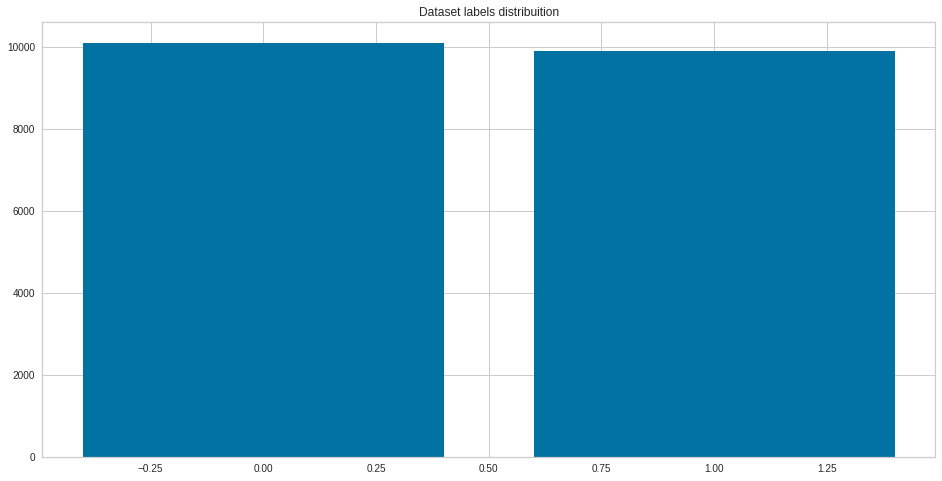

In [0]:
from collections import Counter

target_cnt = Counter(y)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [0]:
print(type(X_train))
print(y_train)
#print(X_test.head())
#print(y_test.head())
#print(X_val.head())
#print(y_val.head())

<class 'pandas.core.series.Series'>
5894     1
3728     1
8958     1
7671     0
5999     1
5751     0
1688     1
6836     0
6536     1
4842     1
15844    1
196      1
518      0
10581    0
13320    1
10790    0
16939    0
841      0
9507     0
10482    1
5174     0
19946    0
14469    0
7608     1
11264    0
14020    0
18601    0
19263    1
7097     1
12596    1
        ..
1267     0
1899     1
3005     0
19118    0
189      0
2747     0
18431    1
18942    0
8666     1
6396     0
19769    0
17568    0
6420     0
5051     0
5311     1
2433     1
769      1
1685     1
8322     0
16023    0
11363    0
14423    1
4426     1
16850    1
6265     1
11284    0
11964    0
5390     0
860      1
15795    1
Name: target, Length: 16000, dtype: int64


In [0]:
import pandas
print(pandas.__version__)

0.23.4


In [0]:
!pip install --upgrade pandas

In [0]:
#CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

#Wersja prawie domyślna
cv = CountVectorizer(stop_words = 'english')
#tekst = X.to_numpy()
X_traincv = cv.fit_transform(X_train)
features = cv.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(X_traincv)
visualizer.poof()

#N-gramy i ograniczenie max i min df
cv2 = CountVectorizer(ngram_range = (1,10), max_df = 0.99, min_df = 0.01, stop_words = 'english')
tekst2 = X.to_numpy()
X = cv2.fit_transform(tekst2)
X.shape
features2 = cv2.get_feature_names()
visualizer = FreqDistVisualizer(features=features2)
visualizer.fit(X)
visualizer.poof()

#Predykcja i metryki

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)
X_train_tfidf.shape

hate_detect_model = MultinomialNB().fit(X_train, y_train)
all_predictions = hate_detect_model.predict(X_test)
print (classification_report(y_test, all_predictions))


In [0]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Image('Figure_1.png')

                precision    recall  f1-score   support

           0       0.78      0.96      0.86      3032
           4       0.59      0.17      0.26       968

### Wczytanie słownika już wygenerowanego

In [0]:
# Slownik : http://vectors.nlpl.eu/repository/
#  no 5 English Wikipedia Dump of February 2017
print('load dict')
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/model.txt', binary=False)
print('load dict')


2019-04-14 10:11:59,837 INFO loading projection weights from /content/gdrive/My Drive/model.txt
2019-04-14 10:11:59,839 WARNING this function is deprecated, use smart_open.open instead
2019-04-14 10:11:59,841 DEBUG {'transport_params': {}, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'rb', 'uri': '/content/gdrive/My Drive/model.txt'}


load dict


2019-04-14 10:13:18,673 INFO loaded (273992, 300) matrix from /content/gdrive/My Drive/model.txt


load dict


### Generowanie słownika na podstawie datasetu

In [0]:

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in dfClean['text']] 

word2vec_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
word2vec_model.build_vocab(documents)

print(type(X_train))

2019-04-14 08:33:38,261 INFO collecting all words and their counts
2019-04-14 08:33:38,262 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-14 08:33:38,299 INFO PROGRESS: at sentence #10000, processed 77735 words, keeping 18030 word types
2019-04-14 08:33:38,338 INFO collected 29768 word types from a corpus of 155946 raw words and 20000 sentences
2019-04-14 08:33:38,340 INFO Loading a fresh vocabulary
2019-04-14 08:33:38,363 INFO effective_min_count=10 retains 2009 unique words (6% of original 29768, drops 27759)
2019-04-14 08:33:38,365 INFO effective_min_count=10 leaves 111168 word corpus (71% of original 155946, drops 44778)
2019-04-14 08:33:38,381 INFO deleting the raw counts dictionary of 29768 items
2019-04-14 08:33:38,384 INFO sample=0.001 downsamples 60 most-common words
2019-04-14 08:33:38,385 INFO downsampling leaves estimated 98977 word corpus (89.0% of prior 111168)
2019-04-14 08:33:38,400 INFO estimated required memory for 2009 words and 300 di

<class 'pandas.core.series.Series'>


In [0]:
words = word2vec_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 3509


In [0]:
print(words)

dict_keys(['half', 'cup', 'coffee', 'sick', 'killer', 'fever', 'migraine', 'sleep', 'getting', 'two', 'youth', 'camp', 'miss', 'already', 'got', 'feet', 'love', 'headache', 'playing', 'bob', 'back', 'concert', 'cute', 'proud', 'need', 'mine', 'home', 'work', 'night', 'could', 'give', 'full', 'grown', 'man', 'hangover', 'yet', 'im', 'still', 'free', 'wheres', 'lol', 'believe', 'stuck', '8', 'clock', 'tonight', 'missing', 'always', 'looks', 'tired', 'wish', 'cheer', 'british', 'dvds', 'series', '2', '3', 'arrived', 'mail', 'today', 'sweet', 'dreams', 'talk', 'later', 'ya', 'good', 'though', 'keeping', 'busy', 'things', 'revising', 'ict', 'messing', 'lately', 'owe', 'million', 'apologies', 'people', 'ugh', 'wanna', 'go', 'vegas', 'ready', 'say', 'earlier', 'thank', 'fun', 'game', 'called', 'old', 'keep', 'sadness', 'national', 'donut', 'day', 'office', 'hurts', 'nobody', 'knows', 'really', 'time', 'july', 'surgery', 'large', 'stone', 'almost', '24', 'p', 'luv', 'another', 'filled', 'sad',

In [0]:
%%time
word2vec_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-04-14 08:30:26,958 INFO training model with 8 workers on 3509 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-04-14 08:30:27,346 DEBUG job loop exiting, total 30 jobs
2019-04-14 08:30:27,443 DEBUG worker exiting, processed 3 jobs
2019-04-14 08:30:27,448 INFO worker thread finished; awaiting finish of 7 more threads
2019-04-14 08:30:27,479 DEBUG worker exiting, processed 4 jobs
2019-04-14 08:30:27,479 INFO worker thread finished; awaiting finish of 6 more threads
2019-04-14 08:30:27,503 DEBUG worker exiting, processed 4 jobs
2019-04-14 08:30:27,503 INFO worker thread finished; awaiting finish of 5 more threads
2019-04-14 08:30:27,510 DEBUG worker exiting, processed 3 jobs
2019-04-14 08:30:27,510 INFO worker thread finished; awaiting finish of 4 more threads
2019-04-14 08:30:27,525 DEBUG worker exiting, processed 3 jobs
2019-04-14 08:30:27,525 INFO worker thread finished; awaiting finish of 3 more threads
2019-04-14 08:30:27,533 INFO worker thread 

CPU times: user 36.1 s, sys: 498 ms, total: 36.5 s
Wall time: 20.5 s


(6906175, 9499136)

In [0]:
word2vec_model.most_similar("hate")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hatred', 0.698973536491394),
 ('despise', 0.6723854541778564),
 ('loathe', 0.6576331853866577),
 ('detest', 0.6529638171195984),
 ('hateful', 0.6341613531112671),
 ('dislikes', 0.6182705760002136),
 ('afraid', 0.6175071001052856),
 ('angry', 0.6059856414794922),
 ('anger', 0.6009637713432312),
 ('ashamed', 0.5991970896720886)]

In [0]:
type(X_train)


pandas.core.series.Series

In [0]:
# Define embedding matrix
embedding_matrix = word2vec_model.wv.syn0
print('Shape of embedding matrix: ', embedding_matrix.shape)

# Vectorize X_train and X_test to 2D tensor
top_words = embedding_matrix.shape[0]

# Define max lenght of sentence and number of classes (negative, neutral and positive)
mxlen = 30
nb_classes = 1

# Tokenize words
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Shape of embedding matrix:  (273992, 300)


In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)


Found 25721 unique tokens.
{'good': 1, 'day': 2, 'like': 3, 'go': 4, 'get': 5, 'quot': 6, 'http': 7, 'going': 8, 'work': 9, 'got': 10, 'today': 11, 'lol': 12, 'love': 13, 'time': 14, 'u': 15, 'back': 16, 'one': 17, 'im': 18, 'com': 19, 'see': 20, 'know': 21, 'really': 22, 'amp': 23, 'new': 24, 'want': 25, 'night': 26, '2': 27, 'home': 28, 'still': 29, 'oh': 30, 'think': 31, 'well': 32, 'thanks': 33, 'need': 34, 'last': 35, 'miss': 36, 'much': 37, 'tomorrow': 38, 'hope': 39, '3': 40, 'twitter': 41, 'great': 42, 'morning': 43, 'haha': 44, 'fun': 45, 'bad': 46, 'sleep': 47, 'wish': 48, 'would': 49, 'feel': 50, 'sorry': 51, 'sad': 52, 'right': 53, 'tonight': 54, 'come': 55, 'getting': 56, 'make': 57, 'could': 58, 'bit': 59, 'week': 60, 'though': 61, 'happy': 62, 'school': 63, 'better': 64, 'way': 65, 'gonna': 66, 'yeah': 67, 'bed': 68, 'wait': 69, 'nice': 70, 'people': 71, 'watching': 72, 'hate': 73, 'twitpic': 74, 'even': 75, 'weekend': 76, 'yes': 77, 'never': 78, '4': 79, 'first': 80, 'n

In [0]:
X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)


print(X_train)

[[    0     0     0 ...    27    11   141]
 [    0     0     0 ...   387  1561   682]
 [    0     0     0 ...  7651    29    13]
 ...
 [    0     0     0 ...  4724   492   124]
 [    0     0     0 ...  3291    77   160]
 [    0     0     0 ... 25721    26  2368]]


In [0]:
nb_epoch = 20
batch_size = 256

# Add embedding_layer weights from existing dictionary and freeze training layer
embedding_layer = Embedding(embedding_matrix.shape[0],
                            output_dim = embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False,
                            input_length=mxlen
                            )
# Model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(embedding_matrix.shape[1], dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(LSTM(80, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

t0 = time()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 30, 300)           82197600  
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 300)           721200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 80)                121920    
_________________________________________________________________
dense_17 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total para

In [0]:


# Measures and confusion matrix

y_pred = model.predict(X_test)
# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_test]
print(yy_true)

yy_scores = [np.argmax(i) for i in y_pred]
print(yy_scores)

print("Recall: " + str(recall_score(yy_true, yy_scores, average='weighted')))
print("Precision: " + str(precision_score(yy_true, yy_scores, average='weighted')))
print("F1 Score: " + str(f1_score(yy_true, yy_scores, average='weighted')))

# Apply Confusion matrix
Y_pred = model.predict(X_val, verbose=2)
y_pred = np.argmax(y_pred, axis=1)

confusion_matrix(yy_true,yy_scores)
#
# out = []
# for i in range(len(X)):
#    out.append('_label_ ' + str(y[i]) + ' ' + X [i].replace("\n",""))
#
# out = pd.DataFrame(out)
# out.to_csv('out.csv',sep='\t',index=False,header=False)




[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

array([[3200]])

In [0]:
t0 = time()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val)

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

%time
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Saving accuracy.PNG to accuracy (1).PNG


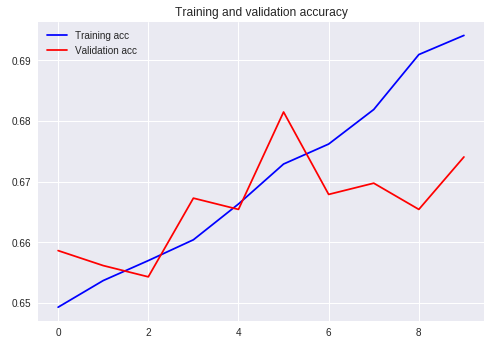

In [0]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()
Image('accuracy.PNG')


Saving LOSS.PNG to LOSS.PNG


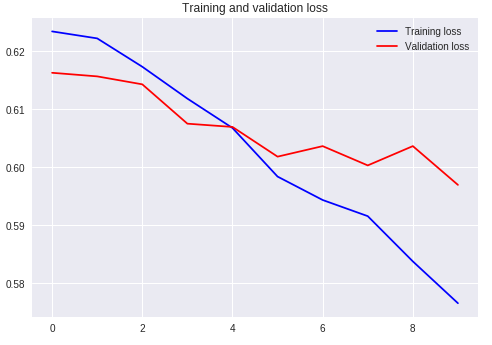

In [0]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()
Image('LOSS.PNG')